In [9]:
#1
!pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn holidays requests shap joblib pulp

In [10]:
#2
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/STLF_project'
for dir_ in ['data', 'models', 'plots', 'logs']:
    os.makedirs(os.path.join(base_path, dir_), exist_ok=True)

sem_file = os.path.join(base_path, 'data', 'SEM.csv')
print("SEM.csv headers:", pd.read_csv(sem_file, nrows=0).columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SEM.csv headers: ['Time', 'BSEB Sch', 'JSEB Sch', 'DVC Sch', 'GRIDCO Sch', 'WBSEB Sch', 'SIKKIM Sch', 'BSEB Act', 'JSEB Act', 'DVC Act', 'GRIDCO Act', 'WBSEB Act', 'SIKKIM Act']


In [11]:
#3
import numpy as np

def load_and_preprocess_data(sem_file, base_path):
    sem_data = pd.read_csv(sem_file, dtype=str)
    sem_data = sem_data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
    if 'Time' not in sem_data.columns:
        raise ValueError("No 'Time' column in SEM.csv")
    sem_data['Time'] = pd.to_datetime(sem_data['Time'], dayfirst=True, errors='coerce')
    bad_rows = sem_data[sem_data['Time'].isnull()]
    if not bad_rows.empty:
        print(f"Dropping {len(bad_rows)} invalid datetimes.")
        sem_data = sem_data.dropna(subset=['Time'])
    sem_data = sem_data.drop_duplicates(subset=['Time']).sort_values('Time').reset_index(drop=True)
    sem_data = sem_data.rename(columns={'Time': 'datetime'}).set_index('datetime')
    demand_cols = [col for col in sem_data.columns if 'Act' in col]

    #outlier capping
    for col in demand_cols:
        sem_data[col] = pd.to_numeric(sem_data[col], errors='coerce')
        p1, p99 = sem_data[col].quantile([0.01, 0.99])
        sem_data[col] = np.clip(sem_data[col], p1, p99)
        sem_data[col] = sem_data[col].interpolate(method='linear').fillna(method='bfill')
    missing_pct = sem_data[demand_cols].isna().mean().mean()
    if missing_pct > 0.01:
        print(f"Warning: {missing_pct:.2%} of demand readings were interpolated.")

    #resample to 5-min
    demand_5min = sem_data[demand_cols]
    idx_5min = pd.date_range(start=demand_5min.index.min(), end=demand_5min.index.max(), freq='5min')
    demand_5min = demand_5min.reindex(idx_5min, method='nearest').interpolate('linear').fillna(method='bfill').fillna(method='ffill')
    output_path = os.path.join(base_path, 'data', 'demand_5min.csv')
    demand_5min.to_csv(output_path, index_label='datetime')
    print(f"Saved demand_5min.csv at {output_path} ({demand_5min.shape})")
    return demand_5min, demand_cols

demand_5min, demand_columns = load_and_preprocess_data(sem_file, base_path)

Dropping 2880 invalid datetimes.


/tmp/ipython-input-2956161694.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sem_data[col] = sem_data[col].interpolate(method='linear').fillna(method='bfill')
/tmp/ipython-input-2956161694.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sem_data[col] = sem_data[col].interpolate(method='linear').fillna(method='bfill')
/tmp/ipython-input-2956161694.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sem_data[col] = sem_data[col].interpolate(method='linear').fillna(method='bfill')
/tmp/ipython-input-2956161694.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sem_data[col] = sem_data[col].interpolate(method='linear').fillna(

Saved demand_5min.csv at /content/drive/MyDrive/STLF_project/data/demand_5min.csv ((105118, 6))


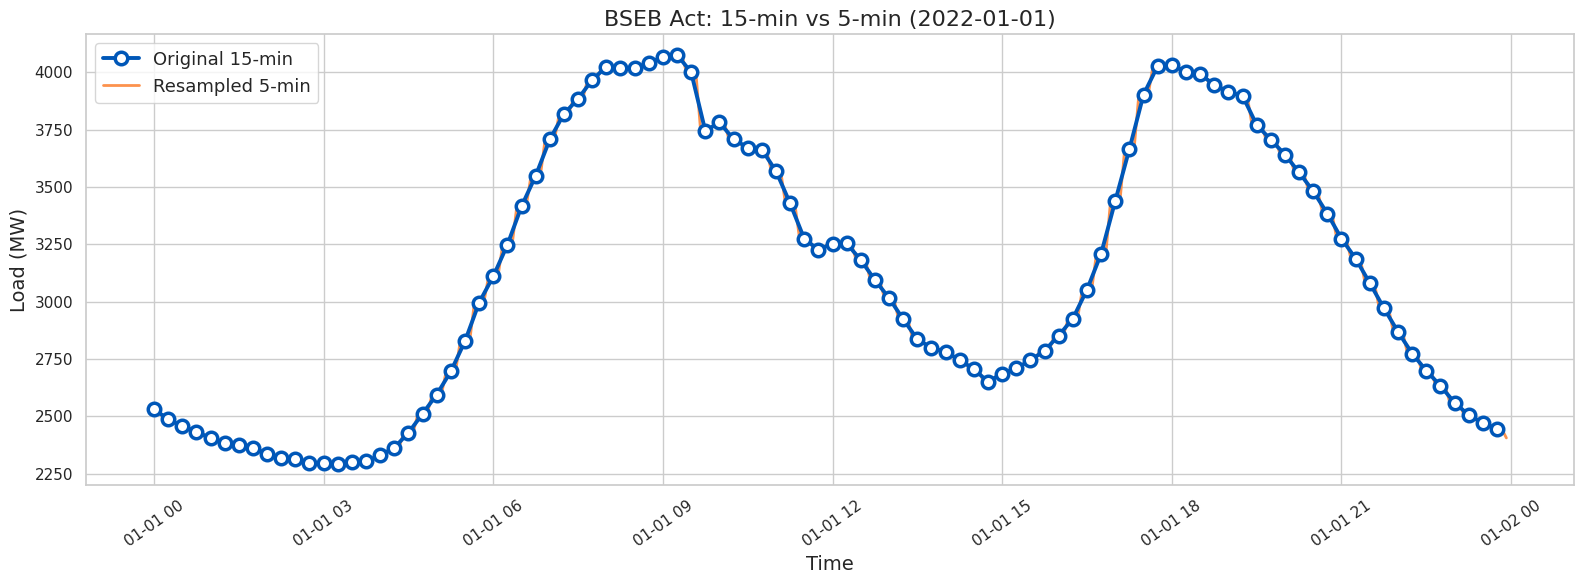

In [12]:
#4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#reload data if variables not in memory
if 'original_15min' not in locals():
    sem_file = os.path.join(base_path, 'data', 'SEM.csv')
    original_15min = pd.read_csv(sem_file, parse_dates=['Time'], dayfirst=True)
    original_15min['Time'] = pd.to_datetime(original_15min['Time'], format='%d-%m-%Y %H:%M', errors='coerce')
    original_15min = original_15min.dropna(subset=['Time']).drop_duplicates(subset=['Time']).sort_values('Time').reset_index(drop=True)
    original_15min = original_15min.set_index('Time')

if 'demand_5min' not in locals():
    demand_5min = pd.read_csv(os.path.join(base_path, 'data', 'demand_5min.csv'), parse_dates=['datetime'], index_col='datetime')

if 'demand_columns' not in locals():
    demand_columns = [col for col in original_15min.columns if 'Act' in col]
demand_col = demand_columns[0] if demand_columns else demand_5min.columns[0]

first_date = max(original_15min.index.min().date(), demand_5min.index.min().date())
plot_day = first_date.isoformat()
day_start, day_end = pd.Timestamp(f"{plot_day} 00:00"), pd.Timestamp(f"{plot_day} 23:59")

if len(original_15min.loc[day_start:day_end]) and len(demand_5min.loc[day_start:day_end]):
    color_15min = "#0057b8"
    color_5min  = "#fc7c29"

    plt.figure(figsize=(16, 6))
    sns.set_theme(style="whitegrid")
    plt.plot(
        original_15min.loc[day_start:day_end].index,
        original_15min.loc[day_start:day_end][demand_col],
        marker='o', markersize=9,
        markerfacecolor='white',  #hollow
        markeredgecolor=color_15min,
        markeredgewidth=2.5,
        color=color_15min,
        linestyle='-',
        linewidth=2.8,
        label='Original 15-min',
        zorder=3
    )
    plt.plot(
        demand_5min.loc[day_start:day_end].index,
        demand_5min.loc[day_start:day_end][demand_col],
        color=color_5min,
        linestyle='-',
        linewidth=2,
        alpha=0.83,
        label='Resampled 5-min',
        zorder=2
    )
    plt.title(f"{demand_col}: 15-min vs 5-min ({plot_day})", fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Load (MW)', fontsize=14)
    plt.xticks(rotation=35)
    plt.legend(fontsize=13, loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No overlapping data to plot for {plot_day}.")

In [13]:
#5
import requests
import holidays

def create_features(demand_5min, base_path):
    idx = demand_5min.index
    f = pd.DataFrame(index=idx)
    try:
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            'latitude': 25.61, 'longitude': 85.14,
            'start_date': idx.min().strftime('%Y-%m-%d'),
            'end_date': idx.max().strftime('%Y-%m-%d'),
            'hourly': 'temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,shortwave_radiation'
        }
        out = requests.get(url, params=params, timeout=30)
        out.raise_for_status()
        weather = pd.DataFrame(out.json()['hourly'])
        weather['time'] = pd.to_datetime(weather['time'])
        weather = weather.set_index('time')
        w5 = weather.reindex(idx.union(weather.index)).interpolate('time').reindex(idx).fillna(method='bfill').fillna(method='ffill')
        for col in weather.columns:
            f[col] = w5[col]
        print("Weather API loaded.")
    except Exception as e:
        print(f"Weather API unavailable. Using synthetic weather. {e}")
        np.random.seed(0)
        f['temperature_2m']   = 25 + 10*np.sin(2*np.pi*idx.hour/24)+np.random.normal(0,2,len(idx))
        f['relative_humidity_2m'] = 70+20*np.sin(2*np.pi*(idx.hour+6)/24)+np.random.normal(0,5,len(idx))
        f['precipitation'] = np.maximum(0, np.random.exponential(0.1, len(idx)))
        f['wind_speed_10m'] = 5+3*np.sin(2*np.pi*idx.hour/24)+np.random.normal(0,1,len(idx))
        f['shortwave_radiation'] = np.maximum(0, 500*np.sin(np.pi*idx.hour/12)+np.random.normal(0,50,len(idx)))
    f['hour'] = idx.hour
    f['day_of_week'] = idx.dayofweek
    f['month'] = idx.month
    f['day_of_year'] = idx.dayofyear
    f['quarter'] = idx.quarter
    f['is_weekend'] = (idx.dayofweek>=5).astype(int)
    f['is_office_hours'] = ((idx.hour>=9)&(idx.hour<=17)&(idx.dayofweek<5)).astype(int)
    f['is_morning_peak'] = ((idx.hour>=6)&(idx.hour<=9)).astype(int)
    f['is_evening_peak'] = ((idx.hour>=18)&(idx.hour<=21)).astype(int)
    india_holidays = holidays.India(years=list(idx.year.unique()))
    f['is_holiday'] = idx.normalize().isin(india_holidays).astype(int)
    f['diwali_effect'] = ((f['month']==10)&(idx.day>=20)&(idx.day<=26)).astype(int)
    f['holi_effect'] = ((f['month']==3)&(idx.day>=15)&(idx.day<=20)).astype(int)
    np.random.seed(42)
    f['economic_index'] = 1+0.1*np.sin(2*np.pi*idx.dayofyear/365)+np.random.normal(0,0.05,len(idx))
    f['social_media_trend'] = np.random.uniform(0,1,len(idx))
    f['traffic_index'] = (np.sin(2*np.pi*idx.hour/24)+1)/2
    f['ev_charging_pattern'] = (((idx.hour>=22)|(idx.hour<=6)).astype(float)*0.3+((idx.hour>=6)&(idx.hour<=10)).astype(float)*0.7)
    for col in demand_5min.columns:
        f[f'{col}_lag1']   = demand_5min[col].shift(1)
        f[f'{col}_lag12']  = demand_5min[col].shift(12)
        f[f'{col}_lag288'] = demand_5min[col].shift(288)
    f.fillna(method='bfill', inplace=True)
    f.fillna(method='ffill', inplace=True)
    feat_path = os.path.join(base_path, 'data', 'features_5min.csv')
    f.to_csv(feat_path, index_label='datetime')
    print(f"Saved features_5min.csv: {feat_path}, shape={f.shape}")
    return f

features_df = create_features(demand_5min, base_path)

/tmp/ipython-input-2569676328.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w5 = weather.reindex(idx.union(weather.index)).interpolate('time').reindex(idx).fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-2569676328.py:43: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  f['is_holiday'] = idx.normalize().isin(india_holidays).astype(int)
/tmp/ipython-input-2569676328.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  f.fillna(method='bfill', inplace=True)
/tmp/ipython-input-2569676328.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future ver

Weather API loaded.
Saved features_5min.csv: /content/drive/MyDrive/STLF_project/data/features_5min.csv, shape=(105118, 39)


In [6]:
#6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Concatenate, Dropout, BatchNormalization, MultiHeadAttention, LayerNormalization

def build_advanced_model(input_shape):
    inputs = Input(shape=input_shape, name='main_input')
    conv1 = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    conv1_bn = BatchNormalization()(conv1)
    conv2 = Conv1D(32, 3, padding='same', activation='relu')(conv1_bn)
    conv2_bn = BatchNormalization()(conv2)
    lstm1 = LSTM(64, return_sequences=True, dropout=0.2)(inputs)
    lstm2 = LSTM(32, return_sequences=True, dropout=0.2)(lstm1)
    attention = MultiHeadAttention(num_heads=4, key_dim=32)(lstm2, lstm2)
    attention_norm = LayerNormalization()(attention)
    combined = Concatenate()([conv2_bn, attention_norm])
    dense1 = Dense(128, activation='relu')(combined)
    dense1_drop = Dropout(0.3)(dense1)
    dense2 = Dense(64, activation='relu')(dense1_drop)
    dense2_drop = Dropout(0.2)(dense2)
    base_dense = Dense(32, activation='relu')(dense2_drop)
    base_output = Dense(1, name='base_output')(base_dense)
    peak_conv = Conv1D(16, 5, padding='same', activation='relu')(inputs)
    peak_lstm = LSTM(16, return_sequences=True)(peak_conv)
    peak_attention = MultiHeadAttention(num_heads=2, key_dim=16)(peak_lstm, peak_lstm)
    peak_dense = Dense(16, activation='relu')(peak_attention)
    peak_output = Dense(1, name='peak_output')(peak_dense)
    seasonal_lstm = LSTM(24, return_sequences=True)(inputs)
    seasonal_attention = MultiHeadAttention(num_heads=2, key_dim=24)(seasonal_lstm, seasonal_lstm)
    seasonal_dense = Dense(12, activation='relu')(seasonal_attention)
    seasonal_output = Dense(1, name='seasonal_output')(seasonal_dense)
    ensemble_inputs = Concatenate()([base_output, peak_output, seasonal_output])
    weighted_sum = Dense(1, use_bias=False, name='weighted_output')(ensemble_inputs)
    final_output = Dense(1, activation='linear', name='final_forecast')(weighted_sum)
    model = Model(inputs=inputs, outputs=final_output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    print("Model built and compiled.")
    return model

Model built and compiled.
Epoch 1/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0703 - mae: 0.2184 - mape: 2599036.2500 - val_loss: 0.0480 - val_mae: 0.1827 - val_mape: 29.0952 - learning_rate: 0.0010
Epoch 2/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 0.0643 - mae: 0.2105 - mape: 2578461.0000 - val_loss: 0.0505 - val_mae: 0.1871 - val_mape: 29.3198 - learning_rate: 0.0010
Epoch 3/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.0644 - mae: 0.2107 - mape: 2584699.0000 - val_loss: 0.0546 - val_mae: 0.1941 - val_mape: 29.6169 - learning_rate: 0.0010
Epoch 4/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.0641 - mae: 0.2104 - mape: 2375322.2500 - val_loss: 0.0530 - val_mae: 0.1915 - val_mape: 29.4859 - learning_rate: 0.0010
Epoch 5/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0638 - mae: 0.2097 - mape: 2552689.5000 - val_loss: 0.0538 - val_mae: 0.1930 - val_mape: 29.7349 - learning_rate: 0.0010
Epoch 6/20
1052/1052 ━━━━━━━━━━━━━━━━━━

y_pred_scaled.shape before slice: (21022, 12, 1)
y_test_orig.shape: (21022,), y_pred_orig.shape: (21022,)

Model Evaluation Metrics:
  MAE            : 1228.5580 MW
  MSE            : 1810008.4315
  RMSE           : 1345.3655 MW
  MAPE           : 46.3341%
  Median AE : 1070.4215 MW
  R2 Score       : -3.7319
  Actual mean±std: 3007.05 ± 618.48 MW
Naive RMSE (previous value): 42.2572 MW


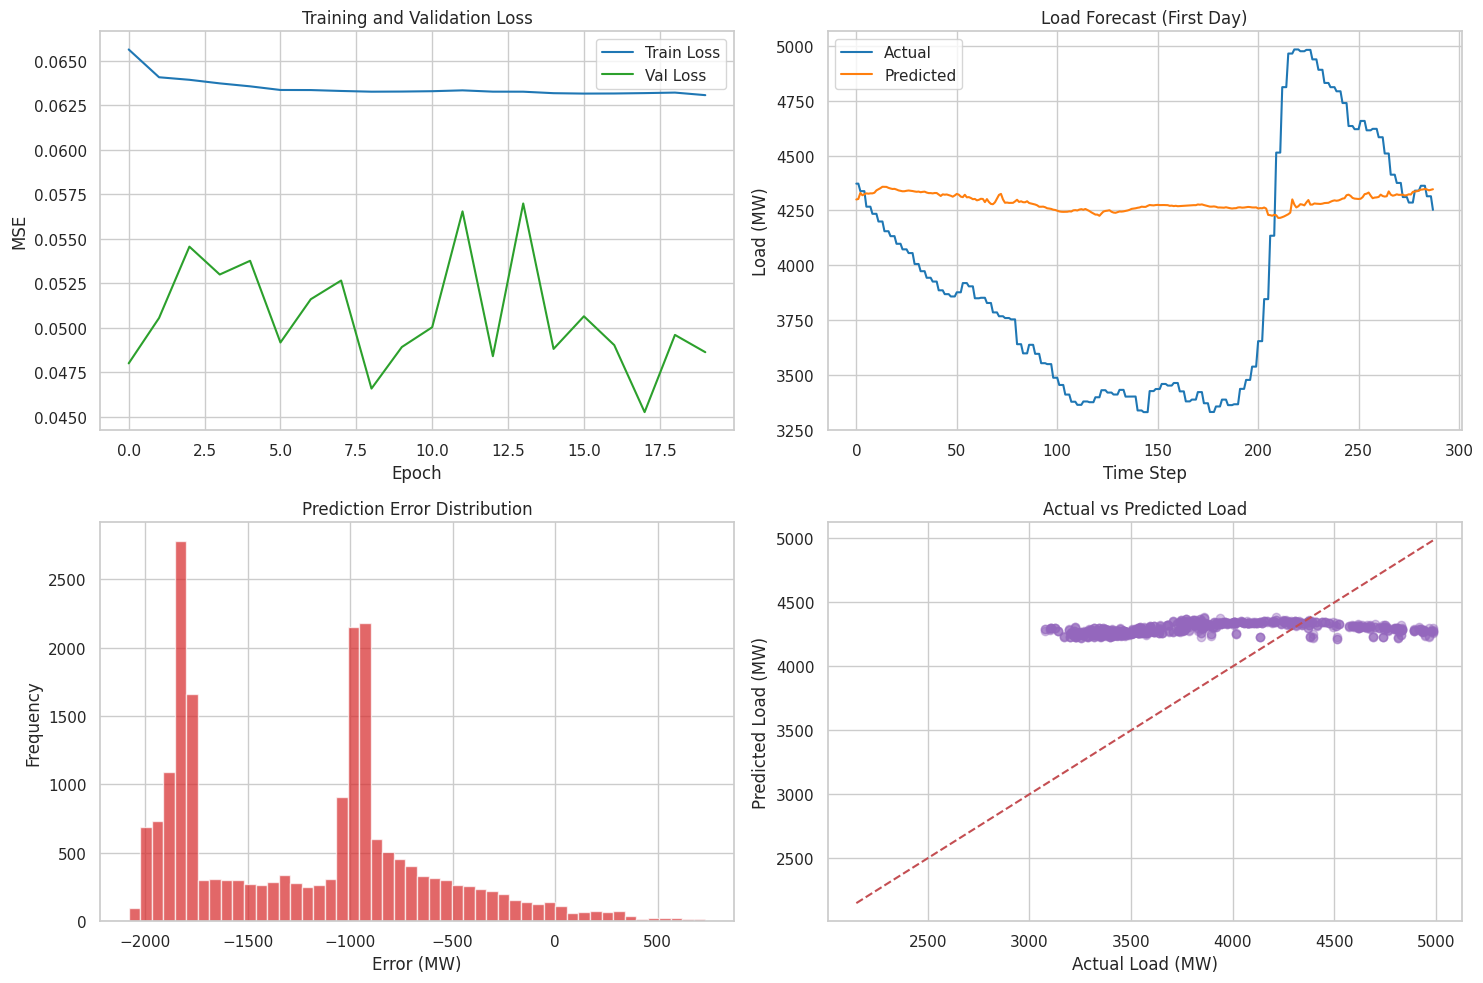

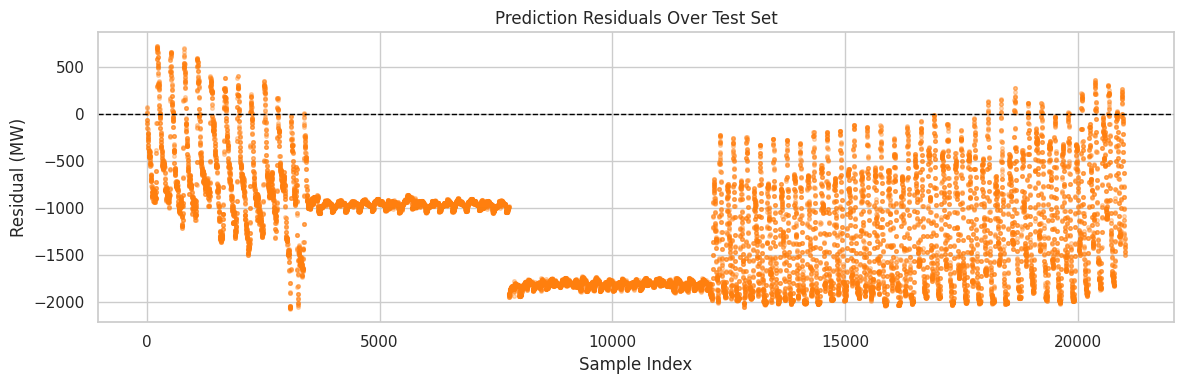

In [15]:
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def train_stlf_model(base_path, seq_len=12):
    #load demand and features CSVs
    demand_df = pd.read_csv(os.path.join(base_path, 'data', 'demand_5min.csv'), parse_dates=['datetime'], index_col='datetime')
    features_df = pd.read_csv(os.path.join(base_path, 'data', 'features_5min.csv'), parse_dates=['datetime'], index_col='datetime')
    target_col = 'BSEB Act'

    if target_col not in demand_df.columns:
        raise KeyError(f"Target '{target_col}' not found in demand_5min.csv.")

    #select features (exclude lag1 features)
    feature_cols = [c for c in features_df.columns if not c.endswith('_lag1')]

    X_all = features_df[feature_cols].values
    y_all = demand_df[target_col].values

    #create supervised learning sequences
    def create_sequences(X, y, seq_len):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_len):
            X_seq.append(X[i:i+seq_len])
            y_seq.append(y[i+seq_len])
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X_all, y_all, seq_len)

    #train-test split 80/20
    train_size = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    #fit scalers only on training data
    scaler_X = MinMaxScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
    scaler_y = MinMaxScaler().fit(y_train.reshape(-1,1))

    #scale train and test sets appropriately
    X_train_scaled = scaler_X.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

    #build model from your build_advanced_model function (import or define separately)
    model = build_advanced_model((X_train.shape[1], X_train.shape[2]))

    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    #train model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    #predict on test set
    y_pred_scaled = model.predict(X_test_scaled)
    print(f"y_pred_scaled.shape before slice: {y_pred_scaled.shape}")

    #model output may be 3D: (samples, seq_len, 1), keep only last time step's prediction
    if y_pred_scaled.ndim == 3:
        y_pred_scaled = y_pred_scaled[:, -1, :]
    if y_pred_scaled.ndim == 2 and y_pred_scaled.shape[1] == 1:
        y_pred_scaled = y_pred_scaled.flatten()

    #inverse transform scaled values back to original scale
    y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()
    y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

    print(f"y_test_orig.shape: {y_test_orig.shape}, y_pred_orig.shape: {y_pred_orig.shape}")

    #ensure shapes match
    if y_test_orig.shape != y_pred_orig.shape:
        raise ValueError(f"Shape mismatch after inverse transform: y_test {y_test_orig.shape}, y_pred {y_pred_orig.shape}")

    #metrics
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / (y_test_orig + 1e-8))) * 100
    med_ae = median_absolute_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)

    print("\nModel Evaluation Metrics:")
    print(f"  MAE            : {mae:.4f} MW")
    print(f"  MSE            : {mse:.4f}")
    print(f"  RMSE           : {rmse:.4f} MW")
    print(f"  MAPE           : {mape:.4f}%")
    print(f"  Median AE : {med_ae:.4f} MW")
    print(f"  R2 Score       : {r2:.4f}")
    print(f"  Actual mean±std: {np.mean(y_test_orig):.2f} ± {np.std(y_test_orig):.2f} MW")

    #naive baseline (previous step value)
    naive_pred = y_test_orig[:-1]
    naive_rmse = np.sqrt(mean_squared_error(y_test_orig[1:], naive_pred))
    print(f"Naive RMSE (previous value): {naive_rmse:.4f} MW")

    #save model and scalers
    model.save(os.path.join(base_path, 'models', 'stlf_model.h5'))
    joblib.dump(scaler_X, os.path.join(base_path, 'models', 'scaler_X.pkl'))
    joblib.dump(scaler_y, os.path.join(base_path, 'models', 'scaler_y.pkl'))

    plt.figure(figsize=(15, 10))
    sns.set_theme(style="whitegrid")
    pal = sns.color_palette("tab10")

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color=pal[0])
    plt.plot(history.history['val_loss'], label='Val Loss', color=pal[2])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(y_test_orig[:288], label='Actual', color=pal[0])
    plt.plot(y_pred_orig[:288], label='Predicted', color=pal[1])
    plt.title('Load Forecast (First Day)')
    plt.xlabel('Time Step'); plt.ylabel('Load (MW)')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.hist(y_test_orig - y_pred_orig, bins=50, color=pal[3], alpha=0.7)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error (MW)'); plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.scatter(y_test_orig[:1000], y_pred_orig[:1000], alpha=0.4, color=pal[4])
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
    plt.title('Actual vs Predicted Load')
    plt.xlabel('Actual Load (MW)')
    plt.ylabel('Predicted Load (MW)')

    plt.tight_layout()
    plt.savefig(os.path.join(base_path, 'plots', 'stlf_results.png'), dpi=300)
    plt.show()

    #test residuals
    plt.figure(figsize=(12,4))
    residuals = y_test_orig - y_pred_orig
    plt.scatter(range(len(residuals)), residuals, color=pal[1], alpha=0.3, s=7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title("Prediction Residuals Over Test Set")
    plt.xlabel("Sample Index")
    plt.ylabel("Residual (MW)")
    plt.tight_layout()
    plt.show()

    return model, (mae, mse, rmse, mape, med_ae, r2), (y_test_orig, y_pred_orig), demand_df, scaler_y, seq_len

model, metrics, (y_test_orig, y_pred_orig), demand_df, scaler_y, seq_len = train_stlf_model(base_path)

ADMS log saved: /content/drive/MyDrive/STLF_project/logs/adms_log.csv
Total load shed interventions: 62
Total load restore interventions: 46


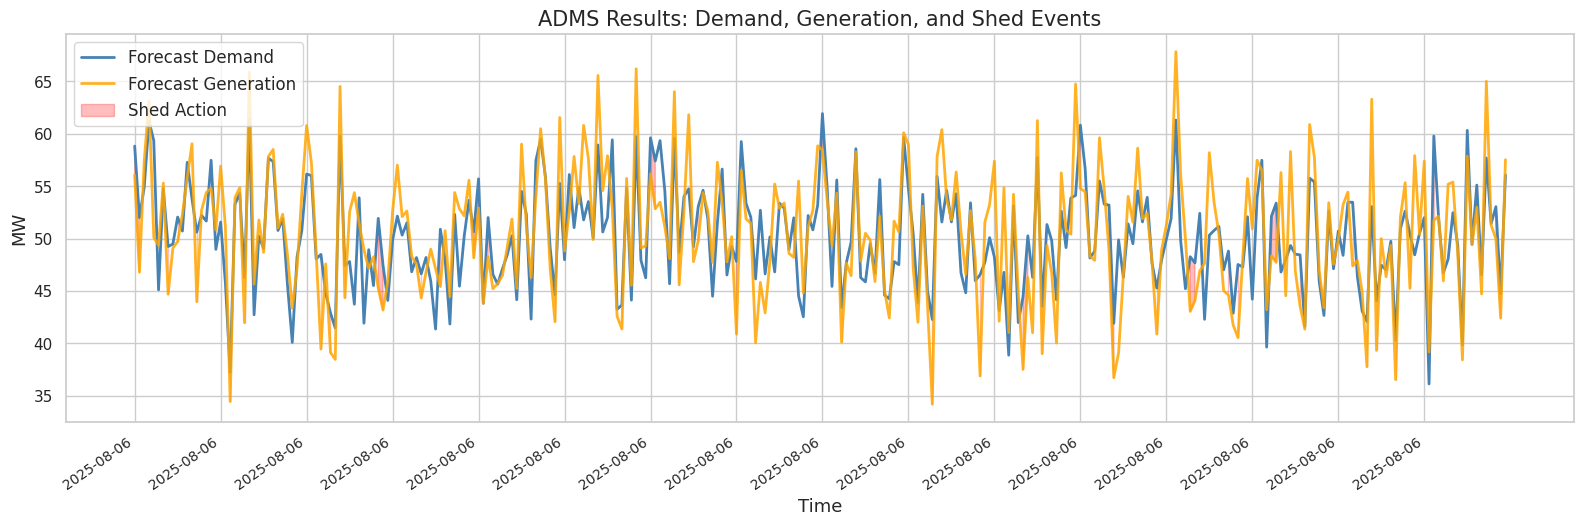

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, PulpSolverError

# =========== 1. LOAD DEMAND & GENERATION FORECASTS ===========
base_path = '/content/drive/MyDrive/STLF_project'  # adjust if needed
demand_file = os.path.join(base_path, "data", "demand_forecast.csv")
generation_file = os.path.join(base_path, "data", "generation_forecast.csv")

#use today for all times
today_str = pd.Timestamp.now().strftime('%Y-%m-%d')

demand_forecast_df = pd.read_csv(demand_file)
generation_forecast_df = pd.read_csv(generation_file)

#standardize time columns: if only HH:MM:SS, prepend today's date
def fix_time_col(df):
    if not any(df['time'].str.contains('-')):
        df['time'] = today_str + ' ' + df['time'].astype(str).str.zfill(8)
    return df

demand_forecast_df = fix_time_col(demand_forecast_df)
generation_forecast_df = fix_time_col(generation_forecast_df)

#merge to get ADMS dataframe (inner join = perfect alignment)
df_adms = pd.merge(
    demand_forecast_df.rename(columns={'demand_mw': 'demand'}),
    generation_forecast_df.rename(columns={'generation_mw': 'generation'}),
    on='time',
    how='inner'
)

if df_adms.empty or len(df_adms) != len(demand_forecast_df) or len(df_adms) != len(generation_forecast_df):
    raise ValueError("Time columns in demand_forecast.csv and generation_forecast.csv do not align perfectly. Please check your data files.")

# =========== 2. DEFINE LOADS & ADMS PARAMETERS ===========
loads = [
    {"name": "EV_charger",      "power": 5, "priority": 3},
    {"name": "AC_unit",         "power": 3, "priority": 2},
    {"name": "Industrial_pump", "power": 7, "priority": 1}
]
load_names = [l["name"] for l in loads]
load_powers = {l["name"]: l["power"] for l in loads}
load_costs = {l["name"]: l["priority"] for l in loads}
load_status = {name: True for name in load_names}
restore_cooldown = {name: 0 for name in load_names}
buffer = 2     #MW
cooldown = 3   #intervals before allow restore

# =========== 3. ADMS LOOP WITH ILP SHEDDING ===========
adms_log = []
for i, row in df_adms.iterrows():
    time = row['time']
    demand = row['demand']
    generation = row['generation']
    imbalance = demand - generation
    action = []
    #decrement cooldowns
    for name in restore_cooldown:
        if restore_cooldown[name] > 0:
            restore_cooldown[name] -= 1
    if imbalance > buffer:
        prob = LpProblem("Shed_Loads", LpMinimize)
        x = {name: LpVariable(name, cat=LpBinary) for name in load_names if load_status[name]}
        prob += lpSum([load_costs[name] * x[name] for name in x]), "TotalShedPriorityCost"
        prob += lpSum([load_powers[name] * x[name] for name in x]) >= imbalance
        try:
            prob.solve()
            for name in x:
                if x[name].varValue == 1:
                    load_status[name] = False
                    restore_cooldown[name] = cooldown
                    action.append(f"shed {name}")
        except PulpSolverError:
            action.append("solver failed")
    elif generation - demand > buffer:
        for name in load_names:
            if not load_status[name] and restore_cooldown[name] == 0:
                load_status[name] = True
                action.append(f"restored {name}")
    adms_log.append({
        "time": time,
        "demand": demand,
        "generation": generation,
        "imbalance": imbalance,
        "action": "; ".join(action) if action else "none"
    })

log_df = pd.DataFrame(adms_log)

# =========== 4. SAVE LOG ===========
adms_log_dir = os.path.join(base_path, "logs")
os.makedirs(adms_log_dir, exist_ok=True)
adms_log_path = os.path.join(adms_log_dir, "adms_log.csv")
log_df.to_csv(adms_log_path, index=False)

if 'action' in log_df.columns:
    shed_count = log_df['action'].str.contains("shed").sum()
    restore_count = log_df['action'].str.contains("restored").sum()
else:
    shed_count = restore_count = 0

print(f"ADMS log saved: {adms_log_path}")
print(f"Total load shed interventions: {shed_count}")
print(f"Total load restore interventions: {restore_count}")

# =========== 5. PROFESSIONAL PLOT ===========
log_df['time'] = pd.to_datetime(log_df['time'])
plt.figure(figsize=(16,5))
sns.set_theme(style="whitegrid")
plt.plot(log_df['time'], log_df['demand'], label='Forecast Demand', color='steelblue', linewidth=2)
plt.plot(log_df['time'], log_df['generation'], label='Forecast Generation', color='orange', linewidth=2, alpha=0.85)
plt.fill_between(
    log_df['time'],
    log_df['demand'],
    log_df['generation'],
    where=log_df['action'].str.contains("shed"),
    color='red',
    alpha=0.26,
    label='Shed Action'
)
plt.title("ADMS Results: Demand, Generation, and Shed Events", fontsize=15)
plt.xlabel("Time", fontsize=13)
plt.ylabel("MW", fontsize=13)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
#subsample x-ticks for clarity
ax = plt.gca()
n_labels = len(log_df['time'])
max_labels = 16
if n_labels > max_labels:
    spacing = n_labels // max_labels
    plt.xticks(log_df['time'][::spacing], rotation=35, ha='right', fontsize=10)
else:
    plt.xticks(rotation=35, ha='right', fontsize=10)
plt.show()